<a href="https://colab.research.google.com/github/kahxuan/chinese-calligraphy-recognition/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kahxuan/chinese-calligraphy-ocr.git

fatal: destination path 'chinese-calligraphy-ocr' already exists and is not an empty directory.


In [2]:
%cd chinese-calligraphy-ocr

/content/chinese-calligraphy-ocr


In [1]:
import os
import yaml
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib as mpl
import matplotlib.pyplot as plt
from modules.model import CRModel, IMG_SIZE, INPUT_SHAPE

tf.config.run_functions_eagerly(True)

config_path = 'config.yaml'

with open(config_path) as file:
    config = yaml.safe_load(file)

data_path = config['dataset']['raw_dir']
config = config['train']

In [4]:
# load dataset

train = image_dataset_from_directory(data_path, 
                                     seed=config['dataset']['seed'],
                                     validation_split=config['dataset']['validation_split'],
                                     shuffle=True, 
                                     batch_size=config['batch_size'], 
                                     image_size=IMG_SIZE, 
                                     subset="training",
                                     label_mode='categorical'
                                    )
val = image_dataset_from_directory(data_path, 
                                   seed=config['dataset']['seed'],
                                   validation_split=config['dataset']['validation_split'],
                                   shuffle=True, 
                                   batch_size=config['batch_size'], 
                                   image_size=IMG_SIZE, 
                                   subset="validation",
                                   label_mode='categorical'
                                  )

# split into validation and test sets
val_batches = tf.data.experimental.cardinality(val)
test_batches = int(float(val_batches) * config['dataset']['test_split'])
test = val.take(test_batches)
val = val.skip(test_batches)

Found 9937 files belonging to 100 classes.
Using 7950 files for training.


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Found 9937 files belonging to 100 classes.
Using 1987 files for validation.


In [5]:
model = CRModel(num_class=config['num_class'])
model.build(input_shape=tuple(INPUT_SHAPE))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=config['optimizer']['lr']),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(train, validation_data=val, epochs=config['epochs'])
loss, accuracy = model.evaluate(test)
print('Test accuracy:', accuracy)

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
image_batch, label_batch = test.as_numpy_iterator().next()
preds = model.predict_on_batch(image_batch)

preds = preds.argmax(axis=1)
labels = label_batch.argmax(axis=1)

print('Predictions', ' '.join([train.class_names[pred] for pred in preds]))
print('Labels     ', ' '.join([train.class_names[label] for label in labels]))

Predictions 个 一 可 子 多 又 在 说 道 用 当 会 所 开 后 得
Labels      个 一 可 子 多 又 在 说 道 用 当 会 所 开 后 得


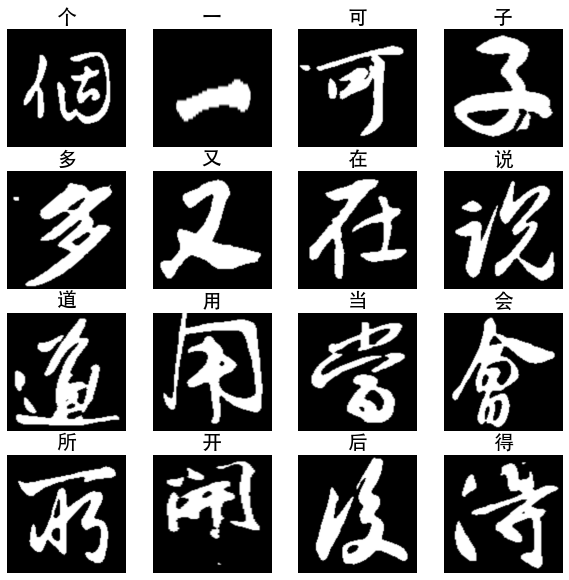

In [15]:
chinese_font = mpl.font_manager.FontProperties(fname='fonts/heiti.ttf')
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(train.class_names[preds[i]], fontproperties=chinese_font, fontsize=20)
    plt.axis("off")